In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import equalize_hist

from src.models import InputImage
from src.utils import create_circle_mask
from src.well import well_hough_transformation


In [10]:
fishy = InputImage("zf4.czi")

## HOUGH TRANSFORM & CIRCLE MASK

# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________


Text(0.5, 1.0, 'mask')

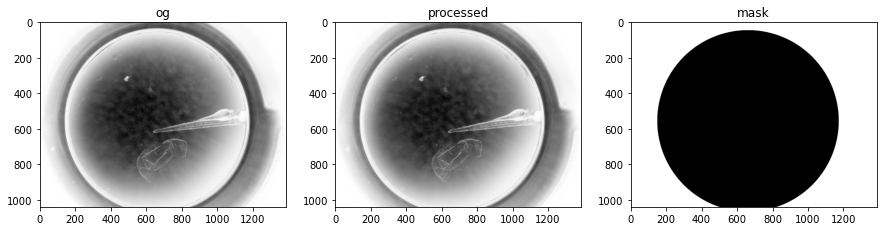

In [11]:
fishy = well_hough_transformation(fishy)
fishy = create_circle_mask(fishy, correction=8)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax = ax.ravel()

ax[0].imshow(fishy.og, 'binary')
ax[0].set_title('og')

ax[1].imshow(fishy.processed, 'binary')
ax[1].set_title('processed')

ax[2].imshow(fishy.well_props.mask.og, 'binary')
ax[2].set_title('mask')

## DEFINING MASKED IMAGES

In [12]:
from skimage.color import rgb2gray
from src.utils import get_bounding_box_obj

bbox = get_bounding_box_obj(fishy.well_props.mask.og)
fishy.well_props.bounding_box = bbox

fishy.well_props.mask.cropped = fishy.well_props.mask.og[bbox.x1:bbox.x2 + 1, bbox.y1:bbox.y2 + 1]

og = fishy.og.astype(np.uint8)
if og.ndim == 3:
    rgb2gray(fishy.og.astype(np.uint8))
masked = fishy.well_props.mask.og.astype(np.uint8) * og
fishy.well_props.mask.masked = masked
fishy.well_props.mask.cropped_masked = masked[bbox.x1:bbox.x2 + 1, bbox.y1:bbox.y2 + 1]

# Storing result
fishy.processed = fishy.well_props.mask.cropped_masked.copy()

Text(0.5, 1.0, 'cropped masked')

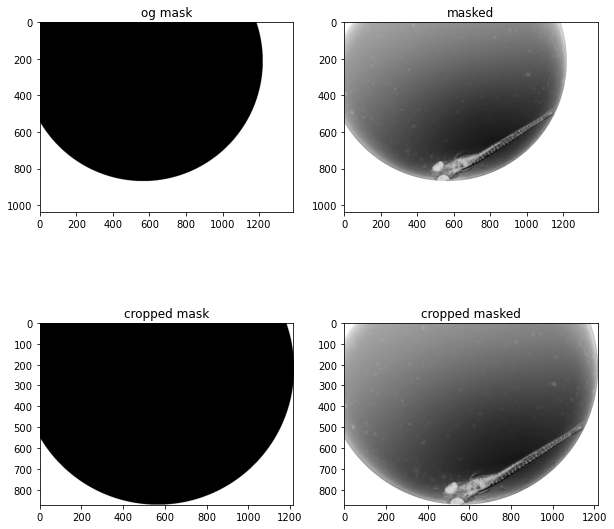

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

ax[0].imshow(fishy.well_props.mask.og, 'binary')
ax[0].set_title('og mask')

ax[1].imshow(fishy.well_props.mask.masked, 'binary')
ax[1].set_title('masked')

ax[2].imshow(fishy.well_props.mask.cropped, 'binary')
ax[2].set_title('cropped mask')

ax[3].imshow(fishy.well_props.mask.cropped_masked, 'binary')
ax[3].set_title('cropped masked')

# FIN
____________________________________________________________________________________________________________________________________________________________________________________

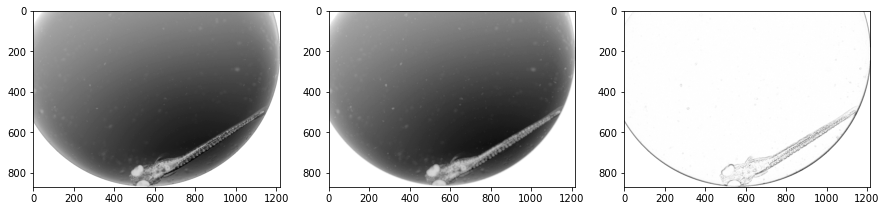

In [7]:
from skimage.restoration import rolling_ball

og = fishy.well_props.mask.cropped_masked
bg = rolling_ball(og)
res = og - bg

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(og, 'binary')
ax[1].imshow(bg, 'binary')
ax[2].imshow(res, 'binary')

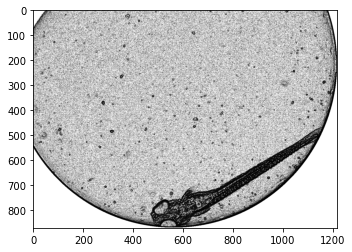

In [8]:
res_ = (equalize_hist(res))
plt.imshow(res_, 'binary')

## Trying to do the matlab remove menisc

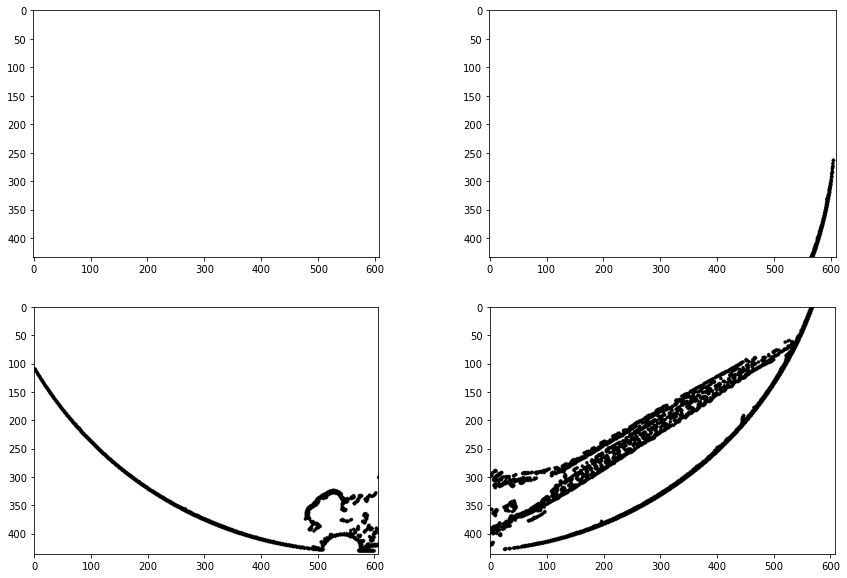

In [9]:
from skimage.morphology import area_opening, disk, binary_erosion, opening
from src.filters import yen_th

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.ravel()

poss_well_thresh = np.zeros_like(res_)
rem_bin = yen_th(res_)

se = disk(10)
eroded_well = binary_erosion(rem_bin, se)

rem_bin[eroded_well > 0] = 0
rem_bin = opening(rem_bin, disk(3))
rem_bin = area_opening(rem_bin, 100)

ch, cw = int(rem_bin.shape[0] / 2), int(rem_bin.shape[1] / 2)
h, w = int(rem_bin.shape[0]), int(rem_bin.shape[1])

lt = rem_bin[1:ch, 1:cw]
lb = rem_bin[ch:h, 1:cw]
rt = rem_bin[1:ch, cw:w]
rb = rem_bin[ch:h, cw:w]

ax[0].imshow(lt, 'binary')
ax[1].imshow(rt, 'binary')
ax[2].imshow(lb, 'binary')
ax[3].imshow(rb, 'binary')